In [1]:
import tensorflow as tf
import utils as utils
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
%matplotlib inline
import itertools
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Activation
from keras.utils import to_categorical
import keras

Using TensorFlow backend.


In [2]:
def killregion(image,xdim,ydim):  
    tempX=image.copy()
    x1=np.min(xdim)
    x2=np.max(xdim)
    y1=np.min(ydim)
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
    #if tempX.ndim ==3:
    #    
    #    for k in range(tempX.shape[0]):
    #        
    #        for i in range(x1,x2):
    #            
    #            for j in range(y1,y2):
    #                
    #                tempX[k,j,i]=0
    #
    #else:
        
    for i in range(x1,x2):
            
        for j in range(y1,y2):
                
            tempX[j,i]=0
                
    return tempX


#help (np.zeros)
def hotregion(image,xdim,ydim):  
    tempX=image.copy()
    x1=np.min(xdim)
    x2=np.max(xdim)
    y1=np.min(ydim)
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
   # if tempX.ndim ==3:
   #     
   #     for k in range(tempX.shape[0]):
   #         
   #         for i in range(x1,x2):
   #             
   #             for j in range(y1,y2):
   #                 
   #                 tempX[k,j,i]=np.max(image)
   # else:
        
    for i in range(x1,x2):
        for j in range(y1,y2):        
            #tempX[j,i]=np.max(image)
            tempX[j,i]=100000
                
    return tempX

def randomregion(image,xdim,ydim):
    
    
    tempX=image.copy()
    x1=abs(np.min(xdim))
    x2=np.max(xdim)
    y1=abs(np.min(ydim))
    y2=np.max(ydim)
    if x1==x2 | y1==y2:
        print "error, no change is made on image"
    #print "x1,x2,y1,y2",x1,x2,y1,y2
    random_noise_region=np.random.randint(np.max(image), size=( abs(x2-x1), abs(y2-y1) ) )   
    #print "random_noise_region.shape",random_noise_region.shape
    

  #  if tempX.ndim == 3:
  #      
  #      for k in range(tempX.shape[0]):
  #          
  #          for i in range(x1,x2):
  #              
  #              for j in range(y1,y2):
  #                  te = i-x1
  #                  te2= j-y1
  #                  tempX[k,j,i]=random_noise_region[te,te2]
  #  
  #  else:
  #      
    for i in range(x1,x2):
            
        for j in range(y1,y2):
            te = i-x1
            te2= j-y1
            tempX[j,i]=random_noise_region[te,te2]
                
    return tempX

In [5]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])
datasampleshape=data_sample.shape

print datasampleshape

data_sample=data_sample[:,:,26:58]
datasampleshape=data_sample.shape
print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)
Shape of random image is:  (0,)

max of image is:  1819.0



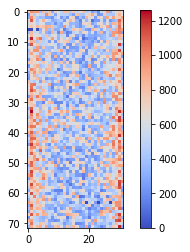

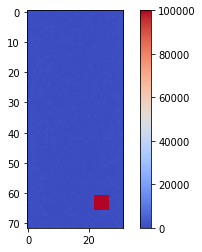

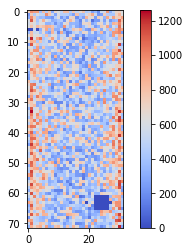

In [8]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]
random_image=[]
count=0
for k in input_images:
    a=np.random.randint(datasampleshape[2]-1)
    b=np.random.randint(datasampleshape[1]-1)
    xdim=(a,a+1)
    ydim=(b,b+1)
    hotregion_image.append( hotregion(k,xdim,ydim))
    deadregion_image.append(killregion(k,xdim,ydim))
    #random_image.append(randomregion(k,xdim,ydim))
    #print "xdim,ydim:",xdim,ydim
    #print count
    count+=1
    
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)
random_image=np.array(random_image)
#print "xdim,ydim",xdim,ydim
print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
print "Shape of random image is: " ,random_image.shape

print '\nmax of image is: ' ,np.max(input_images)
print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


#im=plt.imshow(random_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#
im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


In [6]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(data_sample,deadregion_image,axis=0)
#sample= np.append(sample,random_image,axis=0)            


print sample.shape

(1998, 72, 32)


create the corresponding label matrices

This line of code below was used when the reshping of the images was needed. Now we use a CNN so we don't need to 

For CNN

In [ ]:
X=np.copy(sample)
y=np.zeros((sample.shape[0],1))

-------------- 990
[ 1.  0.]


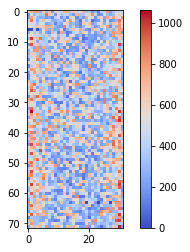

-------------- 991
[ 1.  0.]


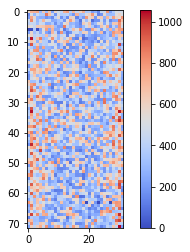

-------------- 992
[ 1.  0.]


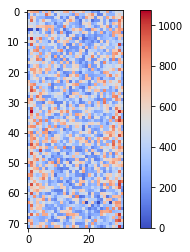

-------------- 993
[ 1.  0.]


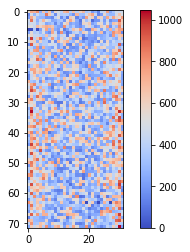

-------------- 994
[ 1.  0.]


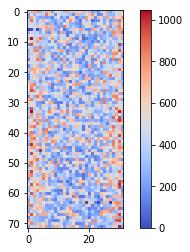

-------------- 995
[ 1.  0.]


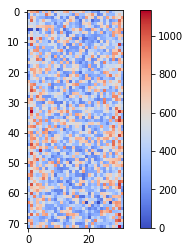

-------------- 996
[ 1.  0.]


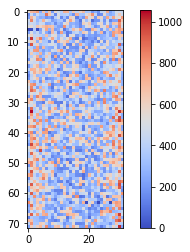

-------------- 997
[ 1.  0.]


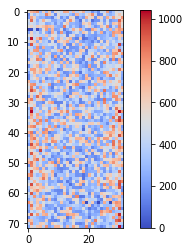

-------------- 998
[ 1.  0.]


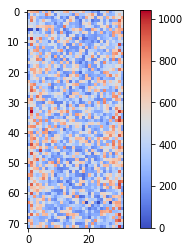

-------------- 999
[ 0.  1.]


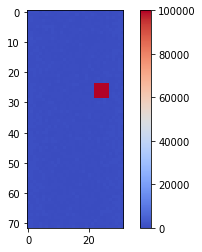

-------------- 1000
[ 0.  1.]


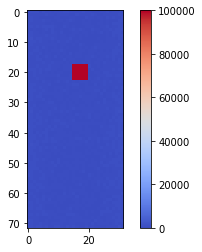

-------------- 1001
[ 0.  1.]


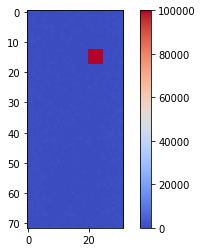

-------------- 1002
[ 0.  1.]


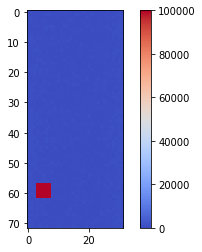

-------------- 1003
[ 0.  1.]


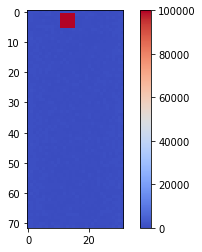

-------------- 1004
[ 0.  1.]


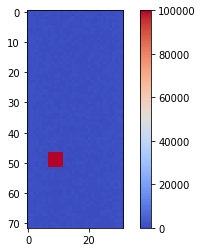

-------------- 1005
[ 0.  1.]


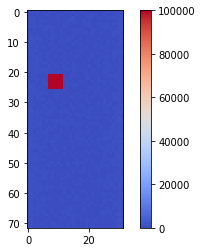

-------------- 1006
[ 0.  1.]


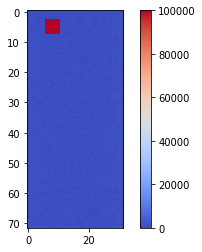

-------------- 1007
[ 0.  1.]


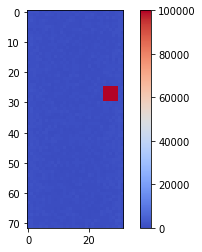

-------------- 1008
[ 0.  1.]


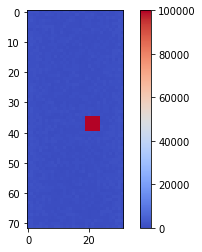

-------------- 1009
[ 0.  1.]


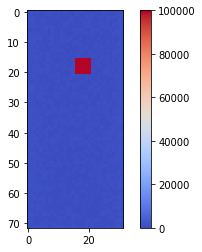

-------------- 1010
[ 0.  1.]


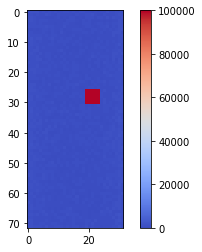

-------------- 1011
[ 0.  1.]


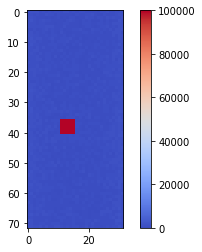

-------------- 1012
[ 0.  1.]


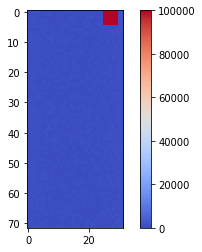

-------------- 1013
[ 0.  1.]


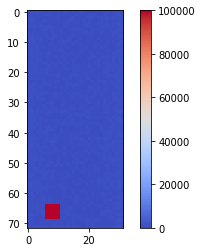

-------------- 1014
[ 0.  1.]


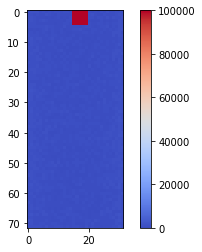

-------------- 1015
[ 0.  1.]


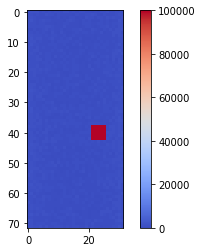

-------------- 1016
[ 0.  1.]


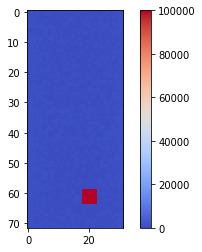

-------------- 1017
[ 0.  1.]


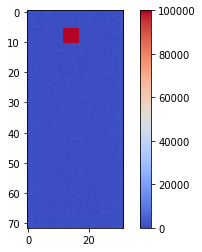

-------------- 1018
[ 0.  1.]


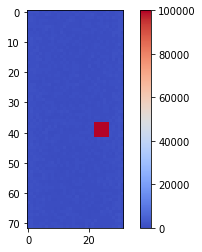

-------------- 1019
[ 0.  1.]


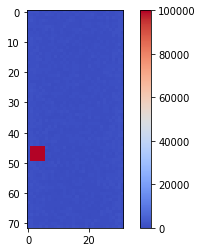

X shape is:  (1998, 72, 32)
y shape is:  (1998, 2)


In [7]:
for i in range(990,1020):
        print '--------------',i
        print y[i]
        im=plt.imshow(X[i],cmap=cm.coolwarm)
        plt.colorbar()
        plt.show()
        plt.clf()

#y=sample[:,-1]
print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

Xtrain.shape (1198, 72, 32)
Xtest.shape (800, 72, 32)
ytrain.shape (1198, 2)
ytest.shape (800, 2)
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
[ 1.  0.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
[ 1.  0.]
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
-------------------
[ 1.  0.]


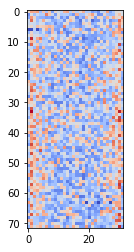

-------------------
[ 0.  1.]


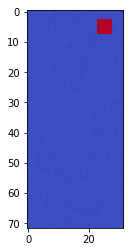

-------------------
[ 1.  0.]


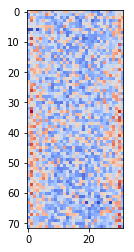

-------------------
[ 0.  1.]


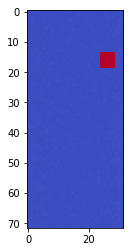

-------------------
[ 1.  0.]


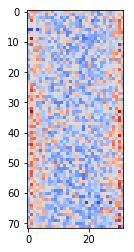

-------------------
[ 1.  0.]


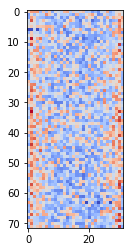

-------------------
[ 1.  0.]


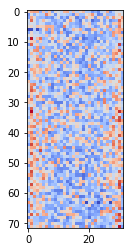

-------------------
[ 0.  1.]


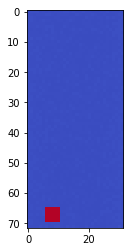

-------------------
[ 1.  0.]


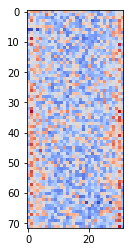

-------------------
[ 1.  0.]


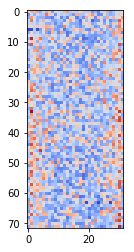

-------------------
[ 1.  0.]


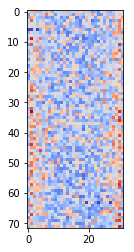

-------------------
[ 1.  0.]


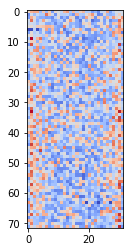

-------------------
[ 1.  0.]


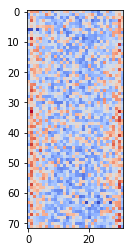

-------------------
[ 0.  1.]


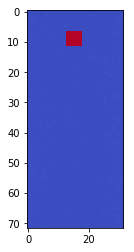

-------------------
[ 1.  0.]


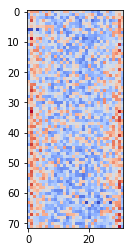

-------------------
[ 1.  0.]


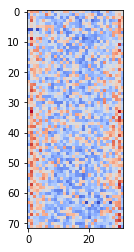

-------------------
[ 1.  0.]


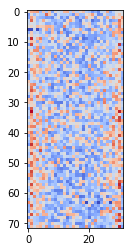

-------------------
[ 0.  1.]


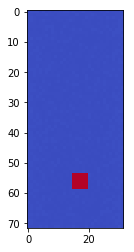

-------------------
[ 0.  1.]


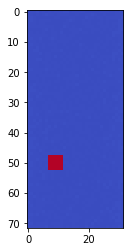

-------------------
[ 0.  1.]


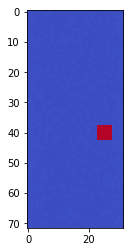

Xtrain.shape after if statement (1198, 72, 32, 1)
Xtest.shape after if statement (800, 72, 32, 1)
ytrain.shape after if statement (1198, 2)
ytest.shape after if statement (800, 2)


In [8]:
Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.2,random_state =5 )
#Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y1,test_size=.4,random_state =5 )
print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape

for i in range(30):
        print ytrain[i]
        
        
for k in range(990,1010):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()


if K.image_data_format() == 'channels_first':
    Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, img_rows, img_cols)
    Xtest = Xtest.reshape(Xtest.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1)
    Xtest = Xtest.reshape(Xtest.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape

# Creating and training the model

In [29]:
# For a single-input model with 2 classes (binary classification):
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#model.add(Conv2D(4, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=5e-4),
              metrics=['accuracy'])


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 72, 32, 1)         4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 35, 15, 8)         80        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 7, 8)          584       
_________________________________________________________________
dropout_3 (Dropout)          (None, 17, 7, 8)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 952)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1906      
Total params: 2,574
Trainable params: 2,572
Non-trainable params: 2
_________________________________________________________________


In [18]:
history = model.fit(Xtrain,ytrain,epochs=50,batch_size=32,verbose=1,validation_data=(Xtest,ytest),shuffle=True)

Train on 1198 samples, validate on 800 samples
Epoch 1/50
1198/1198 [==============================] - 2s 2ms/step - loss: 0.6139 - acc: 0.7646 - val_loss: 0.5106 - val_acc: 0.4725
Epoch 2/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.4548 - acc: 0.9683 - val_loss: 0.4196 - val_acc: 0.5400
Epoch 3/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.3623 - acc: 0.9942 - val_loss: 0.3393 - val_acc: 0.9425
Epoch 4/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.3242 - acc: 0.9992 - val_loss: 0.3095 - val_acc: 1.0000
Epoch 5/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.2710 - acc: 0.9992 - val_loss: 0.1542 - val_acc: 0.9988
Epoch 6/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.0645 - acc: 0.9942 - val_loss: 0.0194 - val_acc: 0.9988
Epoch 7/50
1198/1198 [==============================] - 2s 1ms/step - loss: 0.0256 - acc: 0.9958 - val_loss: 0.0112 - val_acc: 0.9988
Epoch 8/50
1198

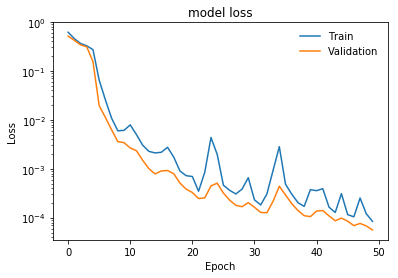

In [23]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history["loss"])
    plt.plot(data.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history, "model loss")